# Computer Vision: Assignment-2

## Mudit Dhawan (2018159)

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Q1

Importing required Libraries

In [2]:
# !pip install scikit-fuzzy

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm

In [5]:
import skimage.io
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
from skimage import morphology

Read the image

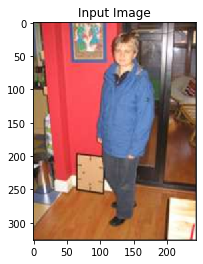

In [6]:
image = skimage.io.imread(fname="Cap1.png")[:,:,:3]
# image = skimage.io.imread(fname="example.jpg")[:,:,:3]

plt.imshow(image)
plt.title("Input Image")
plt.show()

In [7]:
## Create a 2D array with pixel values as their normalized co-ordinates 
img_coords = np.zeros((image.shape[0], image.shape[1], 2))

for row in tqdm(range(img_coords.shape[0])):
    img_coords[row,:,0] = np.ones((img_coords.shape[1],))*row

for col in tqdm(range(img_coords.shape[1])):
    img_coords[:,col,1] = np.ones((img_coords.shape[0],))*col

In [8]:
## Merge the RGB values with xy values 
image_with_coords = np.concatenate((image, img_coords), axis=2)

In [9]:
## Create a Data Array to be clustered 
I = image_with_coords.reshape((-1,5)).T

In [10]:
## Normalize the data using min-max scaler 
row_max = I.max(axis=1)
row_min = I.min(axis=1)
I = (I - row_min[:, np.newaxis]) / row_max[:, np.newaxis]

In [11]:
# parameters for Fuzzy-C-Means Clustering (https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html)
n_centers = 10
fuzziness_degree = 2
error = 0.005
maxiter = 1000

# fuzz c-means clustering
centers, u, u0, d, jm, n_iters, fpc = fuzz.cluster.cmeans(
    I,
    c=n_centers,
    m=fuzziness_degree,
    error=error,
    maxiter=maxiter,
    init=None
)

In [12]:
## Find the membership of each pixel (1D array)
cluster_membership = np.argmax(u, axis=0) 

In [13]:
## convert the membership of each pixel to 2D array
cluster_membership = cluster_membership.reshape((image.shape[0], image.shape[1]))

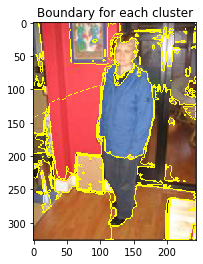

In [14]:
## show the boundaries of the super pixels
plt.imshow(mark_boundaries(image, cluster_membership))
plt.title("Boundary for each cluster")
plt.show()

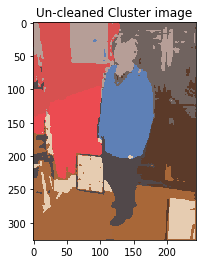

In [15]:
## show the clusters as the average intensity 
plt.imshow(label2rgb(cluster_membership, image, kind='avg',bg_label=-1)/255)
plt.title("Un-cleaned Cluster image")
plt.show()

In [16]:
## Function that cleans the clustered image
def clean_clusters(cluster_membership_raw, area_threshold=100, connectivity=4):
    
    cluster_membership_raw = cluster_membership_raw + 1 # chnage labels 0,1,...n-1 to 1,2,...n
    
    labels, weights = np.unique(cluster_membership_raw, return_counts=True)
    print("Labels:", labels)
    print("Corresponding number of pixels:", weights)
    
    ## create a copy - to store the clean clusters
    cluster_membership_clean = cluster_membership_raw.copy()
    
    ## Loop over all the labels- cleaned clusteres are carry-forwarded to each label  
    for label in labels:
        ## Create a binary image for a particular cluster 
        binary_img = cluster_membership_clean == label

        ## Remove small holes from the binary image 
        mod_binary_image = morphology.remove_small_holes(binary_img, area_threshold=area_threshold, connectivity=connectivity)

        ## Merge the removed holes with cluster and update the clean cluster_membership array
        cluster_membership_clean[mod_binary_image] = label
        cluster_membership_clean[~mod_binary_image] = cluster_membership_clean[~mod_binary_image]
    
    labels, weights = np.unique(cluster_membership_clean, return_counts=True)
    print("Labels:", labels)
    print("Cleaned- Corresponding number of pixels:", weights)
    
    # subtract 1 to change back the numbering of labels 
    return cluster_membership_clean-1

In [17]:
cluster_membership_clean = clean_clusters(cluster_membership, area_threshold=100, connectivity=4)

Labels: [ 1  2  3  4  5  6  7  8  9 10]
Corresponding number of pixels: [ 8852  5957  9637  8858 10143  5743  9262  7005  6090  7997]
Labels: [ 1  2  3  4  5  6  7  8  9 10]
Cleaned- Corresponding number of pixels: [ 8874  5881  9648  8806 10202  5709  9527  6795  6105  7997]


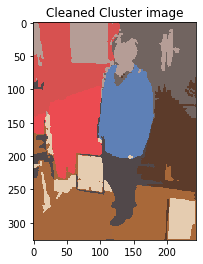

In [18]:
## show the cleaned clustered image as the average intensity of each cluster 
plt.imshow(label2rgb(cluster_membership_clean, image, kind='avg',bg_label=-1)/255)
plt.title("Cleaned Cluster image")
plt.show()